## Loading neccessary Libraries

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io import sql
import sqlite3
import pickle
import plotly.graph_objects as go
import cleantext

import warnings
warnings.filterwarnings('ignore')

In [56]:
#Creating a connection to the db to check tables present.
conn = sqlite3.connect('./im.db')
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table' ;", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


### Loading files into dataframes

In [57]:
movie_basics = pd.read_sql("SELECT * FROM movie_basics;", conn)
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)
bom_movie = pd.read_csv('./bom.movie_gross.csv')

In [58]:
# Preview the first five rowsn of each
display(movie_basics.head())
display(movie_ratings.head())
display(bom_movie.head())

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [59]:
# Checking the number of entries in each
print(f' Shape of movie_basics dataset is: {movie_basics.shape} \n Shape of movie_ratings dataset is: {movie_ratings.shape} \n Shape of bom_movie dataset is: {bom_movie.shape}')

 Shape of movie_basics dataset is: (146144, 6) 
 Shape of movie_ratings dataset is: (73856, 3) 
 Shape of bom_movie dataset is: (3387, 5)


### Observation

movie basics and movie rating have a primart key that is unique, so we can do a FULL JOIN

In [60]:
# q = """
# SELECT * 
# FROM movie_basics
# FULL JOIN movie_ratings
#     USING(movie_id)
# ;"""
# combined_db = pd.read_sql(q, conn)

# # save the combined DataFrame in the .sav format using the pickle.dump() function
# with open('combined_db.sav', 'wb') as f:
#     pickle.dump(combined_db, f)


#### Loading the IMDb file takes forever, hence i will save them in .sav format which is allowed by pickle library of Python, this will speed up data loading processes everytime we load

In [61]:
# To load the saved file
with open('combined_db.sav', 'rb') as f:
    combined_db = pickle.load(f)

combined_db

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0
...,...,...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,NaN,NaN
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary,NaN,NaN
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy,NaN,NaN
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None,NaN,NaN


## DATA CLEANING

### drop unnecessary columns

In [62]:
# drop original title and numvotes
combined_db = combined_db.drop(['original_title', 'numvotes'], axis=1)

In [63]:
#check for null
(combined_db.isnull().mean() * 100).round(2)

movie_id            0.00
primary_title       0.00
start_year          0.00
runtime_minutes    21.72
genres              3.70
averagerating      49.46
dtype: float64

### get the summary statistics to know what to do with the missing values

In [64]:
combined_db.describe(include='all')

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating
count,146144,146144,146144.000000,114405.000000,140736,73856.000000
unique,146144,136071,NaN,NaN,1085,NaN
top,tt0063540,Home,NaN,NaN,Documentary,NaN
freq,1,24,NaN,NaN,32185,NaN
mean,NaN,NaN,2014.621798,86.187247,NaN,6.332729
std,NaN,NaN,2.733583,166.360590,NaN,1.474978
min,NaN,NaN,2010.000000,1.000000,NaN,1.000000
25%,NaN,NaN,2012.000000,70.000000,NaN,5.500000
50%,NaN,NaN,2015.000000,87.000000,NaN,6.500000
75%,NaN,NaN,2017.000000,99.000000,NaN,7.400000


In [65]:
# Basically there is no outlier in the runtime_minutes and averagerating; therefore we can replace with mean

combined_db['runtime_minutes'] = combined_db['runtime_minutes'].fillna(combined_db['runtime_minutes'].mean().round())

combined_db['averagerating'] = combined_db['averagerating'].fillna(combined_db['averagerating'].mean().round())

# for genre we drop missing values
combined_db = combined_db.dropna(subset = ['genres'])

In [66]:
# Check for null
combined_db.isna().sum()

movie_id           0
primary_title      0
start_year         0
runtime_minutes    0
genres             0
averagerating      0
dtype: int64

In [68]:
# Check duplicates and drop duplicates of there are any

combined_db.drop_duplicates
combined_db

# No duplicates confirmed. Time for exploration!

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9
3,tt0069204,Sabse Bada Sukh,2018,86.0,"Comedy,Drama",6.1
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5
...,...,...,...,...,...,...
146138,tt9916428,The Secret of China,2019,86.0,"Adventure,History,War",6.0
146139,tt9916538,Kuambil Lagi Hatiku,2019,123.0,Drama,6.0
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,86.0,Documentary,6.0
146141,tt9916706,Dankyavar Danka,2013,86.0,Comedy,6.0


In [78]:
# # Heatmap

# # Create a correlation matrix to relationship of the variables
# corrMatrix = combined_db.corr()
# corrMatrix

# # Vizualise the correlation matrix using a heat map

# fig, ax = plt.subplots(figsize=(40,15)) 
# sns.heatmap(corrMatrix, annot=True,  linewidths=.1, ax=combined_db)

## Lets Have a look at Bom_movie dataset

In [80]:
# Have a glance at the dataset
bom_movie

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [81]:
# check for missing values
bom_movie.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [82]:
# Lets get the summaryu statistics to decide what to do with the missing values
bom_movie.describe(include='all')

,title,studio,domestic_gross,foreign_gross,year
count,3387,3382,3.359000e+03,2037,3387.000000
unique,3386,257,NaN,1204,NaN
top,Bluebeard,IFC,NaN,1200000,NaN
freq,2,166,NaN,23,NaN
mean,NaN,NaN,2.874585e+07,NaN,2013.958075
std,NaN,NaN,6.698250e+07,NaN,2.478141
min,NaN,NaN,1.000000e+02,NaN,2010.000000
25%,NaN,NaN,1.200000e+05,NaN,2012.000000
50%,NaN,NaN,1.400000e+06,NaN,2014.000000
75%,NaN,NaN,2.790000e+07,NaN,2016.000000


Assumptions:  
Drop null in studio.  
Replace nulls with median in the domestic_gross and foreign_gross columns.

In [84]:
# Remove some special characters(Remove extraneous comma) from the column then convert it to float datatype
bom_movie['foreign_gross'] = bom_movie['foreign_gross'].apply(lambda x: float(str(x).replace(',', '')))

# convert dtype in foreign gross to float
bom_movie['foreign_gross'] = bom_movie['foreign_gross'].astype(float)

In [85]:
# replace missing values with median in domestic_gross and foreign_gross
bom_movie['domestic_gross'] = bom_movie['domestic_gross'].fillna(bom_movie['domestic_gross'].median())
bom_movie['foreign_gross'] = bom_movie['foreign_gross'].fillna(bom_movie['foreign_gross'].median())


# I will drop genres with missing values
bom_movie = bom_movie.dropna(subset=['studio'])

In [88]:
# add a new column for Total Profit
bom_movie["Total Gross"] = bom_movie["domestic_gross"] + bom_movie["foreign_gross"]
bom_movie

,title,studio,domestic_gross,foreign_gross,year,Total Gross
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08
...,...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,18700000.0,2018,1.870620e+07
3383,Edward II (2018 re-release),FM,4800.0,18700000.0,2018,1.870480e+07
3384,El Pacto,Sony,2500.0,18700000.0,2018,1.870250e+07
3385,The Swan,Synergetic,2400.0,18700000.0,2018,1.870240e+07


In [89]:
# check possibility of anymore Nulls
bom_movie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3382 entries, 0 to 3386
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3382 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3382 non-null   float64
 3   foreign_gross   3382 non-null   float64
 4   year            3382 non-null   int64  
 5   Total Gross     3382 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 185.0+ KB


We can merge the two columns as primary title has movies similar in titles.  
This is so as to get the genres there movies are in.  
But first lets rename primary title to title

In [91]:
combined_db = combined_db.rename(columns={'primary_title' : 'title'})

In [92]:
# Is there any relationship between the two?
display(combined_db.columns)
display(bom_movie.columns)

Index(['movie_id', 'title', 'start_year', 'runtime_minutes', 'genres',
       'averagerating'],
      dtype='object')

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year',
       'Total Gross'],
      dtype='object')

In [95]:
# Join the two tables on the 'title' columns
merged_df = pd.merge(combined_db, bom_movie, left_on='title', right_on='title')

merged_df

,movie_id,title,start_year,runtime_minutes,genres,averagerating,studio,domestic_gross,foreign_gross,year,Total Gross
0,tt0315642,Wazir,2016,103.0,"Action,Crime,Drama",7.1,Relbig.,1100000.0,18700000.0,2016,19800000.0
1,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,IFC,744000.0,8000000.0,2012,8744000.0
2,tt2404548,On the Road,2011,90.0,Drama,6.0,IFC,744000.0,8000000.0,2012,8744000.0
3,tt3872966,On the Road,2013,87.0,Documentary,6.0,IFC,744000.0,8000000.0,2012,8744000.0
4,tt4339118,On the Road,2014,89.0,Drama,6.0,IFC,744000.0,8000000.0,2012,8744000.0
...,...,...,...,...,...,...,...,...,...,...,...
3318,tt8404272,How Long Will I Love U,2018,101.0,Romance,6.5,WGUSA,747000.0,82100000.0,2018,82847000.0
3319,tt8427036,Helicopter Eela,2018,135.0,Drama,5.4,Eros,72000.0,18700000.0,2018,18772000.0
3320,tt8851262,Spring Fever,2019,86.0,"Comedy,Horror",6.0,Strand,10800.0,150000.0,2010,160800.0
3321,tt9078374,Last Letter,2018,114.0,"Drama,Romance",6.4,CL,181000.0,18700000.0,2018,18881000.0


### What makes a movie highly rated?
### What impact does the genre have?
### What impact does the runtime_minutes have?

### My Approach is to first perform EDA on combined_db then on merged_df

# (i) EDA on combined_db

### a) Genre Analysis 

Need to understand which genres are produced more, as this has a correlation to audience preference




In [96]:
# count by genre
combined_db["genres"].value_counts().head()

genres
Documentary     32185
Drama           21486
Comedy           9177
Horror           4372
Comedy,Drama     3519
Name: count, dtype: int64

<Axes: title={'center': 'TOP 5 GENRES COLLECTIVELY'}, ylabel='count'>

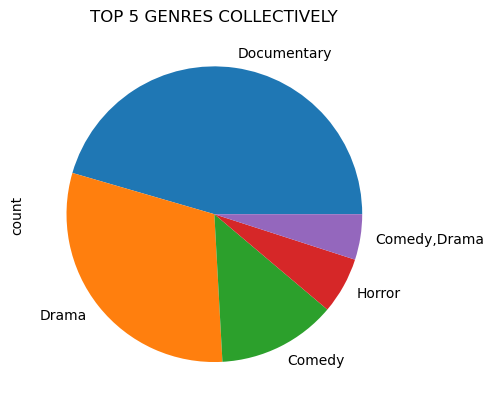

In [100]:
# visualizing cont by genre
# plot the pie chart

top5_genres = combined_db["genres"].value_counts().head()
plt.title('TOP 5 GENRES COLLECTIVELY')

top5_genres.plot.pie()

#### Observation:  
Documentaries take up the largest, followed by drama then comedy

#### A movie might belong to many genres which are comma separated in our dataset.  
#### Let's go on a rolercoaster ride and split the genres!

In [101]:
# split the genres
all_genres = [pd.Series(row['start_year'], row['genres'].split(",")) for _, row in combined_db.iterrows()]
all_genres = pd.concat(all_genres).reset_index()


all_genres.columns = ['genre', 'year']
all_genres['year'] = all_genres['year'].astype('str')


In [106]:
# counting each genre for each year.
year_genre = pd.pivot_table(all_genres,  index=['year'], columns=['genre'], aggfunc= len,fill_value=0)

# add a Total column to sum per year
year_genre['Total'] = year_genre.sum(axis = 1)

year_genre

genre,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,Total
year,,,,,,,,,,,,,,,,,,,,,
2010,891,0,502,198,793,2179,537,4393,4297,479,...,7,848,242,0,186,3,832,140,38,19275
2011,912,0,581,256,889,2328,572,4754,4526,599,...,0,847,276,1,218,4,909,138,44,20924
2012,919,1,638,243,1011,2484,601,5221,4800,677,...,5,870,284,1,219,4,1016,136,45,22565
2013,1008,0,792,255,1253,2653,717,5575,5356,864,...,9,1034,356,0,275,4,1245,119,41,25281
2014,1073,3,795,280,1375,2811,748,5972,5478,876,...,8,1139,353,0,278,4,1318,171,63,26764
2015,1092,2,714,310,952,2748,737,6028,5492,680,...,19,1082,388,0,255,11,1327,170,53,25637
2016,1207,5,708,301,818,2853,860,6066,5593,594,...,19,1075,380,0,275,8,1395,164,40,25868
2017,1257,4,671,335,746,2791,776,6133,5615,578,...,15,975,422,4,234,2,1371,161,54,25613
2018,1128,9,616,339,590,2834,730,5302,5626,566,...,11,982,390,5,200,7,1486,143,59,24263


In [104]:
year_genre.columns

Index(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show',
       'Thriller', 'War', 'Western', 'Total'],
      dtype='object', name='genre')

#### Observations
Documentary is the most common genre overall over the years.  
Some aother quite rare genres like Game-Show seem to be trending recently.

### Fact: Movies often have genres that overlap, such as adventure in a spy movie, or crime in a science fiction movie.  
### One of the great things about a movie that blends genres is the diversity it brings to the table. These movies can appeal to a wide range of audiences, combining the elements that different people love about different genres. A movie that blends comedy and drama, for example, can make us laugh and cry in the same setting.  
### source: https://movieweb.com/best-movies-that-blend-genres/


### Suggestion: I would recommend Microsoft to do movie blending based on above information. Based on what customers have a preference of, they can create a hybrid movie with those genres
### If we have data, let's look at data. If all we have are opinions, let's go with mine. ~ James Love Barksdale

#### How does the different genres are distributed over the years

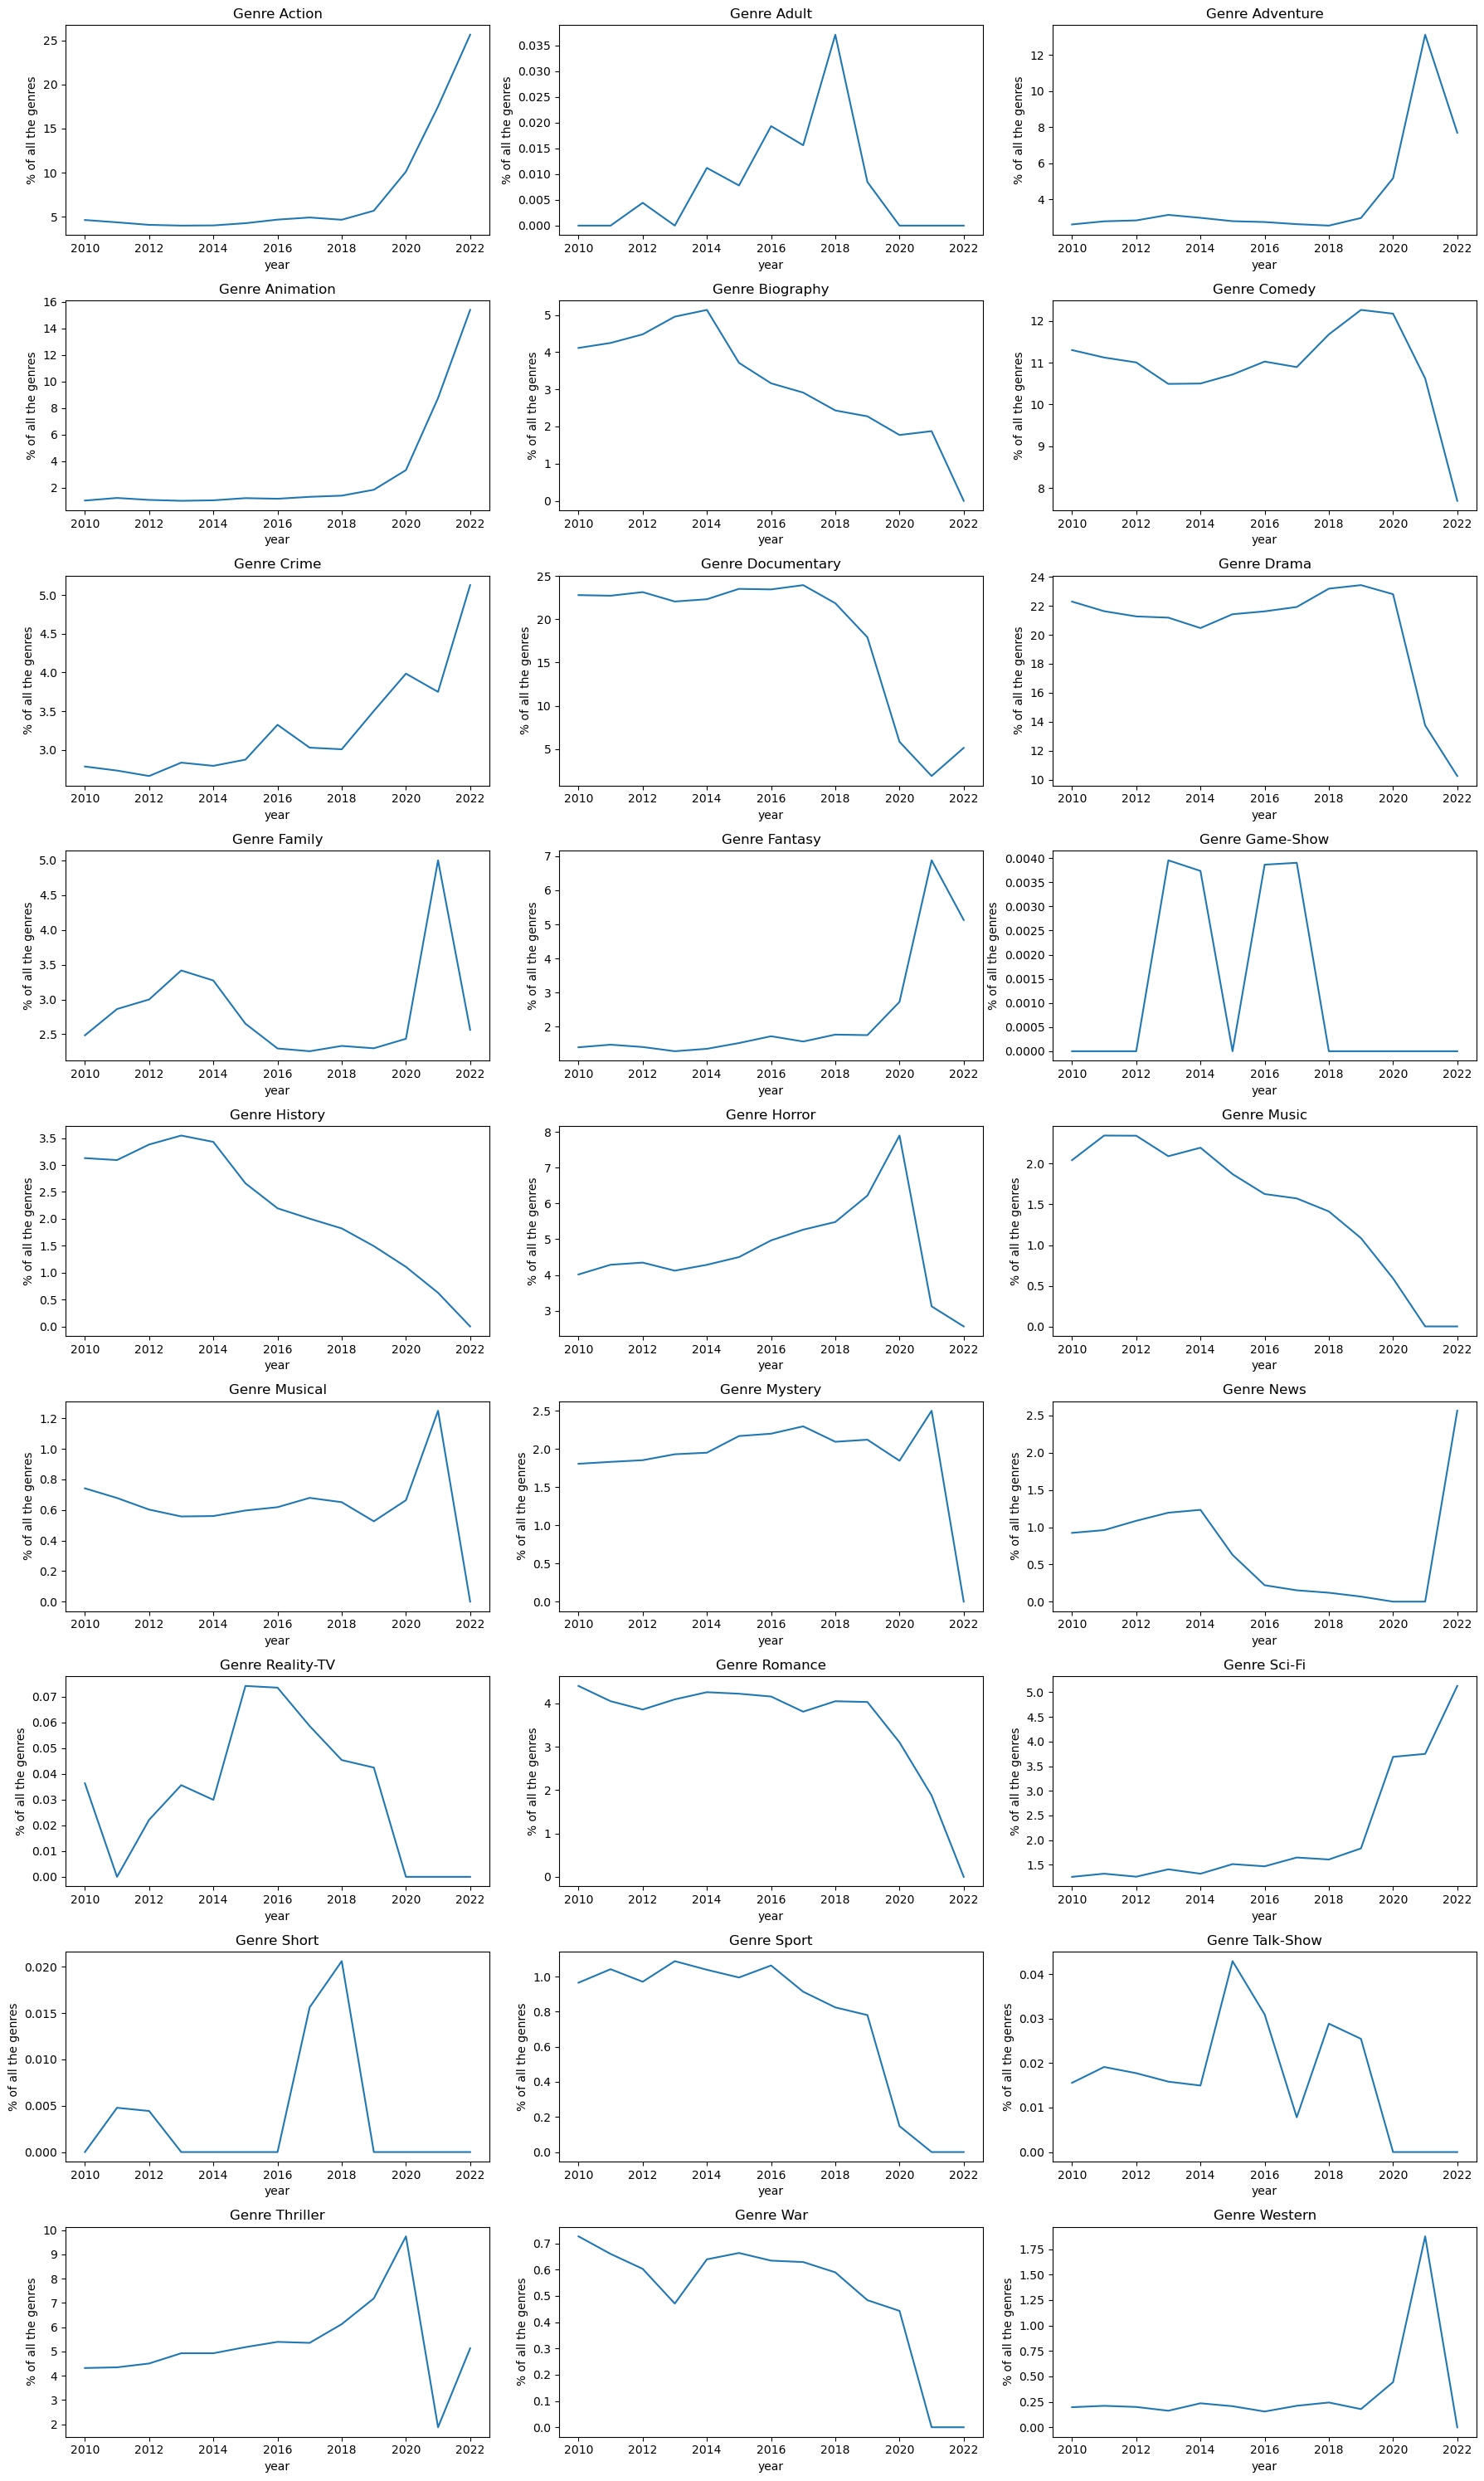

In [108]:
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(18, 30))

for i, column in enumerate(year_genre.columns[:-1]):
    row = i // 3
    col = i % 3
    ax = axes[row][col]
    
    (year_genre[column]*100/year_genre['Total']).sort_index().loc[:'2022'].plot(
        title=f"Genre {column}", 
        ylabel='% of all the genres', 
        ax=ax
    )

plt.tight_layout()
plt.show()


## Observations
Some movies genre trends lasted for few years while others dominated throughout the years.  

Some have gained popularity very recently like Sci-Fi, animation and news genre  

Documentary, comedy and Biography was doing so well at some point dropped significantly. Assumption: Could be due to popularity of youtube an Netflix domain

### b) Runtime analysis

In [109]:
runtime_count = combined_db["runtime_minutes"].value_counts()
runtime_count.head(10)

runtime_minutes
86.0     30362
90.0      7050
80.0      3460
85.0      2882
100.0     2635
95.0      2518
75.0      2458
60.0      2336
88.0      2049
93.0      2047
Name: count, dtype: int64

### Observation
There is a preference in movies with a shorter runtime of around 87 minutes. This is the average time movie lasts. Longer films have a harder time holding audience attention  
Extrapolting this, shorter runtime means it can be screened many times a day at box office, increasing revenue.  
Hence I would recommend producing a movie within that duration span

### c) Rating analysis

In [112]:
# low rated movies
lowratedmovies= combined_db.query('(averagerating > 0) & (averagerating <= 3.0)').sort_values(by='averagerating', ascending=True)

lowratedmovies

,movie_id,title,start_year,runtime_minutes,genres,averagerating
27845,tt2087999,Transgender Trouble,2011,100.0,"Documentary,Music",1.0
83767,tt4839424,The Autobots,2015,85.0,"Adventure,Animation,Family",1.0
136038,tt8654080,Overdose of Gore: Crime born Crime,2015,46.0,Horror,1.0
85181,tt4932436,"Girls, Dance with the Dead",2015,70.0,Comedy,1.0
85287,tt4937514,A Light in the Distance,2014,53.0,Drama,1.0
...,...,...,...,...,...,...
28742,tt2109116,Desaparecidos,2011,72.0,"Horror,Thriller",3.0
94771,tt5526660,Odnoklassnitsy,2016,80.0,"Comedy,Romance",3.0
29117,tt2120022,"Banshchik prezidenta, ili Pasechniki Vselennoy",2010,86.0,Comedy,3.0
103257,tt6047468,Tales for the Campfire,2016,65.0,Horror,3.0


In [113]:
#high rated movies
highratedmovies= combined_db.query('(averagerating >= 7.0) & (averagerating <= 10.0)').sort_values(by='averagerating', ascending=False)

highratedmovies

,movie_id,title,start_year,runtime_minutes,genres,averagerating
120109,tt7227500,Ellis Island: The Making of a Master Race in A...,2018,70.0,"Documentary,History",10.0
16767,tt1770682,Freeing Bernie Baran,2010,100.0,"Crime,Documentary",10.0
85712,tt4960818,Revolution Food,2015,70.0,Documentary,10.0
85426,tt4944240,Dog Days in the Heartland,2017,86.0,Drama,10.0
117359,tt6991826,A Dedicated Life: Phoebe Brand Beyond the Group,2015,93.0,Documentary,10.0
...,...,...,...,...,...,...
62333,tt3589172,Os fenómenos,2014,99.0,Drama,7.0
62293,tt3587834,The King of Jokgu,2013,100.0,"Comedy,Sport",7.0
62284,tt3587486,La película de Ana,2012,86.0,Comedy,7.0
62037,tt3576118,Conversa com JH,2013,93.0,"Documentary,Sport",7.0


#### Observation:  
The most rated movie is documentary

# (ii) EDA on merged_df  
Main Objective here is to check the relation with gross revenue brought by movies.  
Assumption: Here we will not split the genre column

In [116]:
# Glance at the dataset
merged_df

,movie_id,title,start_year,runtime_minutes,genres,averagerating,studio,domestic_gross,foreign_gross,year,Total Gross
0,tt0315642,Wazir,2016,103.0,"Action,Crime,Drama",7.1,Relbig.,1100000.0,18700000.0,2016,19800000.0
1,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,IFC,744000.0,8000000.0,2012,8744000.0
2,tt2404548,On the Road,2011,90.0,Drama,6.0,IFC,744000.0,8000000.0,2012,8744000.0
3,tt3872966,On the Road,2013,87.0,Documentary,6.0,IFC,744000.0,8000000.0,2012,8744000.0
4,tt4339118,On the Road,2014,89.0,Drama,6.0,IFC,744000.0,8000000.0,2012,8744000.0
...,...,...,...,...,...,...,...,...,...,...,...
3318,tt8404272,How Long Will I Love U,2018,101.0,Romance,6.5,WGUSA,747000.0,82100000.0,2018,82847000.0
3319,tt8427036,Helicopter Eela,2018,135.0,Drama,5.4,Eros,72000.0,18700000.0,2018,18772000.0
3320,tt8851262,Spring Fever,2019,86.0,"Comedy,Horror",6.0,Strand,10800.0,150000.0,2010,160800.0
3321,tt9078374,Last Letter,2018,114.0,"Drama,Romance",6.4,CL,181000.0,18700000.0,2018,18881000.0


#### Genre VS Total Revenue over the years

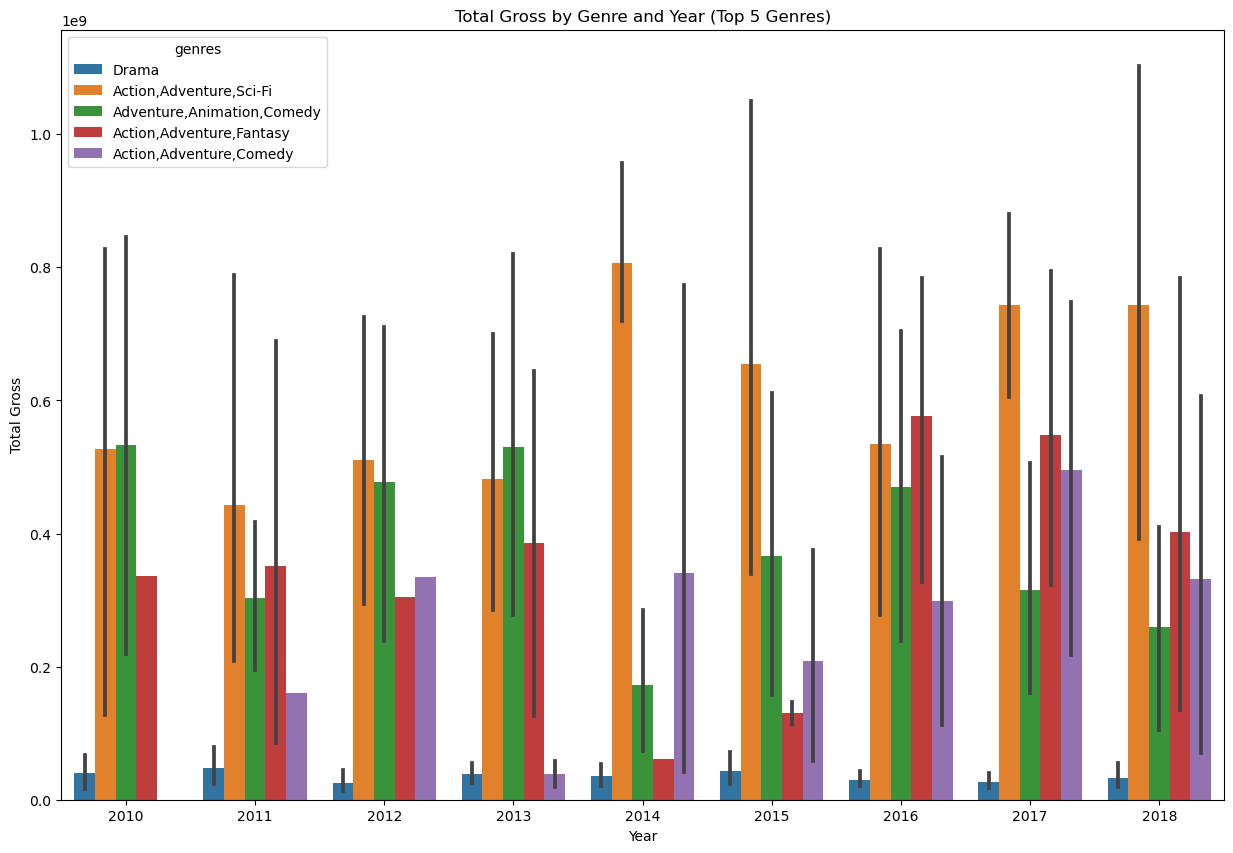

In [124]:
#Group the data by genre and calculate total gross for each genre
genre_gross = merged_df.groupby('genres')['Total Gross'].sum()

# Select the top 5 genres by total gross
top_5_genres = genre_gross.nlargest(5).index.tolist()

# Filter the data to only include the top 5 genres
genre_year_gross = merged_df.loc[merged_df['genres'].isin(top_5_genres)]

# Plot a bar chart of the total gross by genre and year
plt.figure(figsize=(15, 10))
sns.barplot(x='year', y='Total Gross', hue='genres', data=genre_year_gross)
plt.title('Total Gross by Genre and Year (Top 5 Genres)')
plt.xlabel('Year')
plt.ylabel('Total Gross')
plt.show()

### Observation 
Action, Adventure, SciFi movies are doing the best.  

I will recomment creating a movie that contains Action, Adventure, SciFi as over the years it has the highest gross sales

### Lets find out who our biggest competitors will be in terms of market share

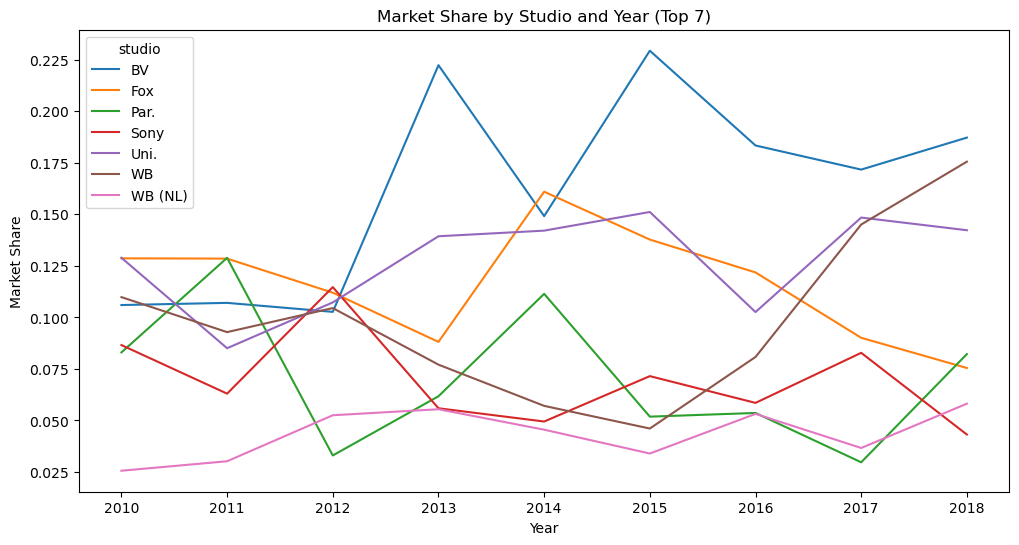

In [127]:
# Calculate the market share of each studio by year
studio_market_share = merged_df.groupby(['year', 'studio'])['Total Gross'].sum().reset_index()
studio_market_share['market_share'] = studio_market_share['Total Gross'] / studio_market_share.groupby('year')['Total Gross'].transform('sum')

# Get the top 7 studios by total gross
top_studios = merged_df.groupby('studio')['Total Gross'].sum().nlargest(7).index

# Filter the studio_market_share DataFrame to include only the top studios
studio_market_share = studio_market_share[studio_market_share['studio'].isin(top_studios)]

# Plot a line chart of the market share of the top studios by year
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='market_share', hue='studio', data=studio_market_share)
plt.title('Market Share by Studio and Year (Top 7)')
plt.xlabel('Year')
plt.ylabel('Market Share')
plt.show()

### Observations
 
 Based on the data available, BM has been a leader in total gross production between 2015–2018, followed by Fox and Par.  
 Assumption: Total Gross produced by a Studio is an indicator of whether they are a market leader.

### Domestic gross VS Foreign gross over the years

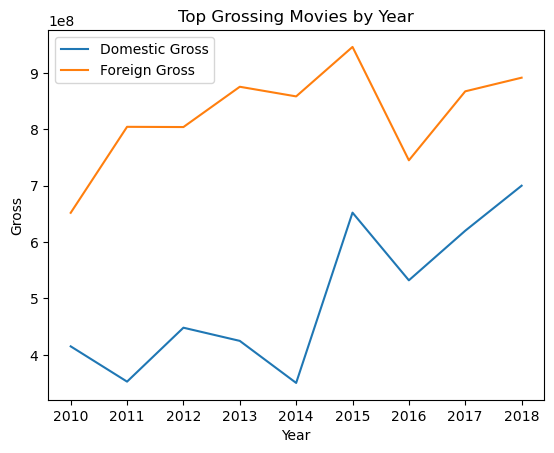

In [128]:
yearly_gross = merged_df.groupby('year')[['domestic_gross', 'foreign_gross']].max()
yearly_gross.plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Gross')
plt.title('Top Grossing Movies by Year')
plt.legend(['Domestic Gross', 'Foreign Gross'])
plt.show()

### Observation
More revenue comes from the foreign market than the domestic market.  
This is an indication to produce movies that favour both markets in form of the content and language  